# Logistic regression with Tensorflow


## What is Logistic regression ?
Logistic regression uses probabilities to distinguish inputs and thereby puts 
them into separate bags of output classes. To better understand how this process works, let’s look at an example.

> To predict whether an email is spam (1) or (0)

Consider a scenario where we need to classify whether an email is spam or not. If we use linear regression for this problem, there is a need for setting up a threshold based on which classification can be done for example 0.5.

From this example, it can be inferred that linear regression is not suitable for classification problem. Linear regression never deals with probabilistic values. It simply draws a linear interpolation between data points .

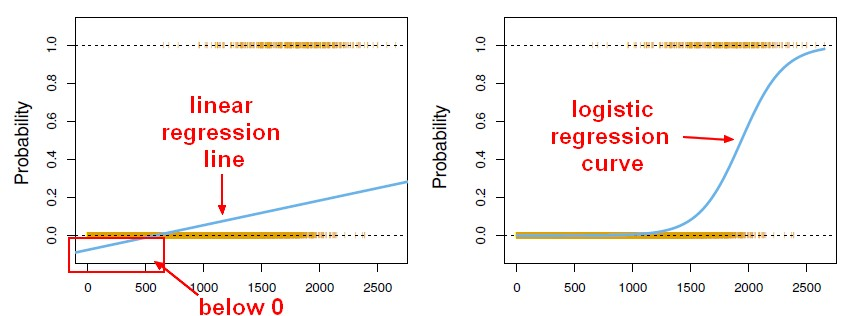

Therefore, linear regression isn’t sufficient for solving classification problems.
 * May result to negative probabilities
 * Not going high enough (might be solved by changing 0.5)



# Binary Logistic Regression
Binary Logistic Regression, in which the target variable has only two possible values, e.g., pass/fail or win/lose.

We want to model the probability of being in class one, 𝜌(𝑋) = Pr( 𝑌=1 |𝑋)
And probability of being in class zero is: 1 − 𝜌(𝑋) .

linear regression model the probability as: 

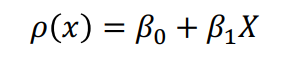

  * It may lead to negative probability + not good for more than two levels

Logistic Regression model the probability as:

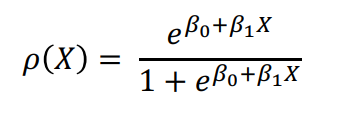

* Ensures that our estimate for p(X) lies between 0 and 1.

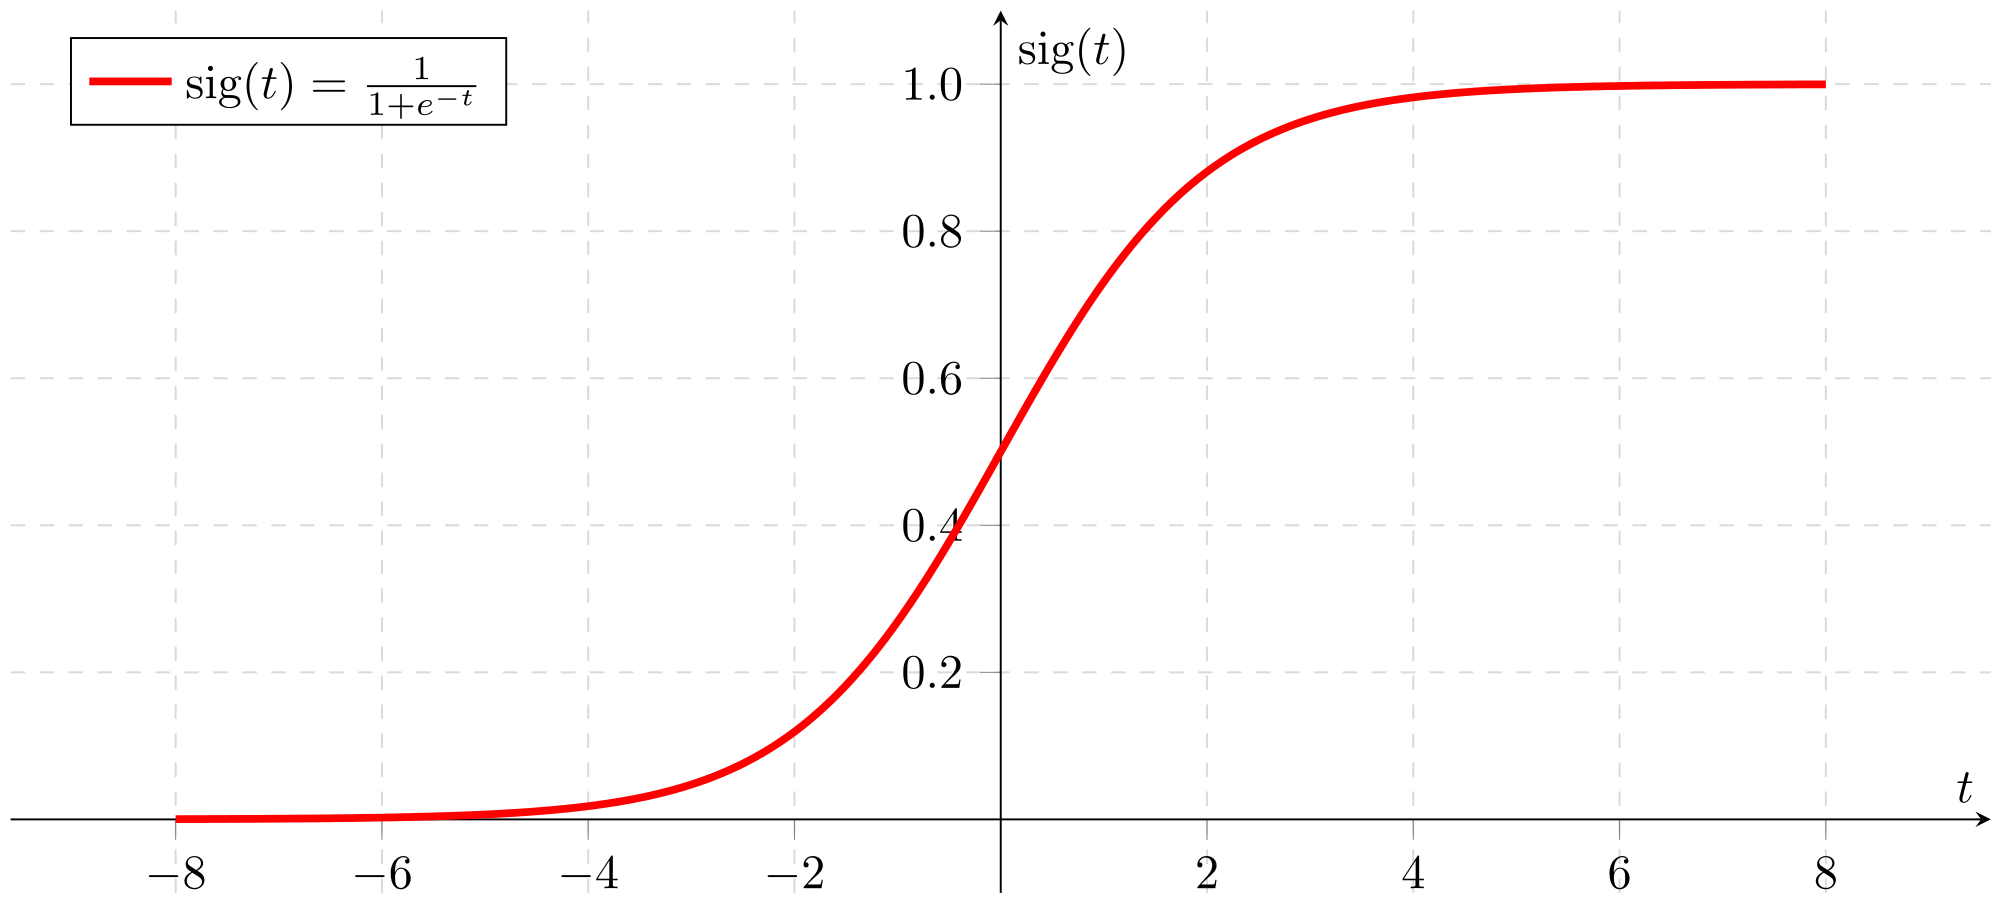

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model
from sklearn.metrics import accuracy_score ,roc_curve ,confusion_matrix 

plt.style.use('seaborn')

# Load data set
notMNIST data set is a data set with 10 classes, (letters A-J taken from different fonts). Here are some examples of letter "A" .

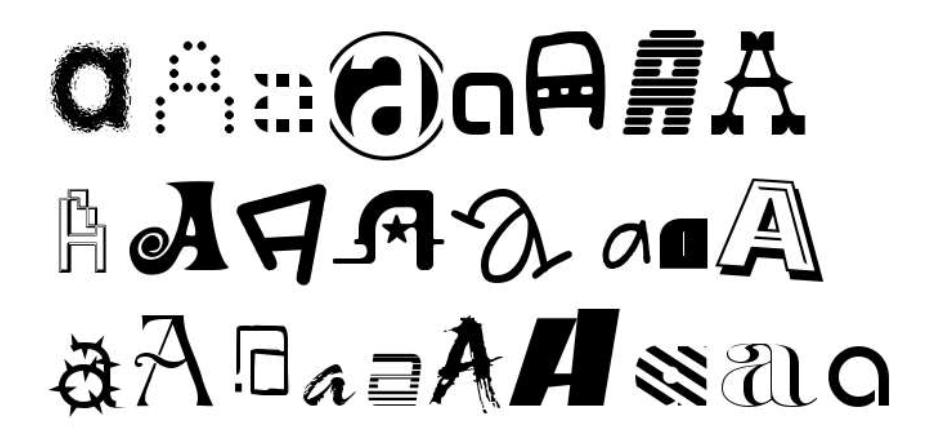

We want to build a model differentiating between letters “C” and “J”.

In [19]:
with np.load("notMNIST.npz") as data :
    Data, Target = data ["images"], data["labels"]
    posClass = 2    
    negClass = 9    
    dataIndx = (Target==posClass) + (Target==negClass)
    SubData = Data[:,:,dataIndx[:,0]]/255
    SubTarget = Target[dataIndx].reshape(-1, 1)
    SubTarget[SubTarget==posClass] = 1  
    SubTarget[SubTarget==negClass] = 0  
    np.random.seed(521)
    randIndx = np.arange(SubData.shape[2])
    np.random.shuffle(randIndx)
    SubData, SubTarget = SubData[:,:,randIndx], SubTarget[randIndx]
    SubTarget = SubTarget.astype(np.float32)
    SubData = SubData.astype(np.float32)
    trainData, trainTarget = SubData[:,:,:3500], SubTarget[:3500]
    validData, validTarget = SubData[:,:,3500:3600], SubTarget[3500:3600]
    testData, testTarget = SubData[:,:,3600:], SubTarget[3600:]


trainData=trainData.transpose(2,0,1).reshape(3500,784)
validData= validData.transpose(2,0,1).reshape(100,784)
testData=testData.transpose(2,0,1).reshape(-1,784)


Now we have 3500 training images, 100 validation images and 141 test images.
Take a look at some images

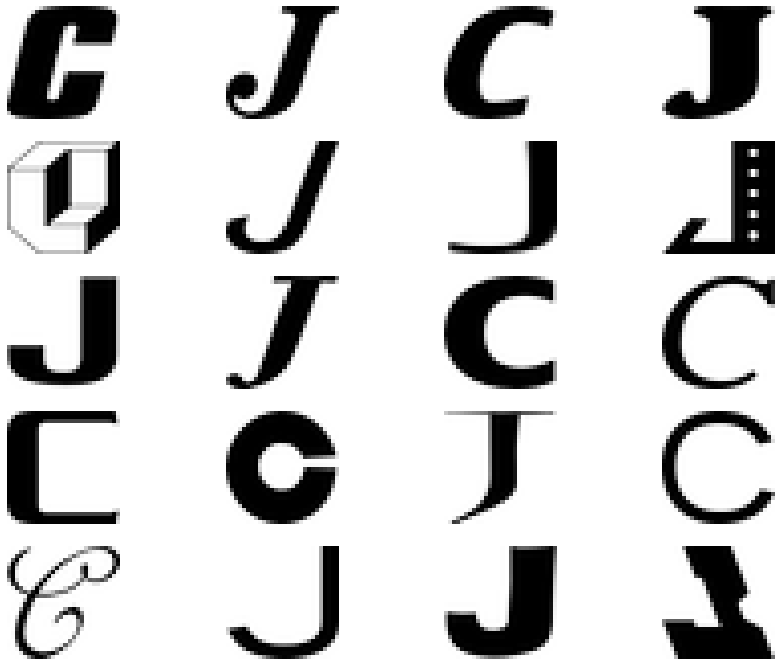

In [20]:
fig = plt.figure(figsize=(15,12))

for i in range(20):
  ax = fig.add_subplot(5,4, i+1)
  ax.imshow(trainData[i].reshape(28,28))
  ax.axes.get_xaxis().set_visible(False)
  ax.axes.get_yaxis().set_visible(False)


# Maximum likelihood
Linear regression uses ordinary least squares method to minimie the errors and arrive at a best possible fit, while logistic regression uses maximum likelihood method to arrive at the solution.

Based on the training data,

* If we know '𝑥𝑖' is in class 1, i.e. (𝑥𝑖, 1), we want 𝜌(𝑥𝑖) to be as large as possible (close to one)
* If we know '𝑥𝑖' is in class 0, i.e. (𝑥𝑖, 0), we want 
1 − 𝜌(𝑥𝑖) to be as large as possible (𝜌(𝑥𝑖) close to zero).

So ,

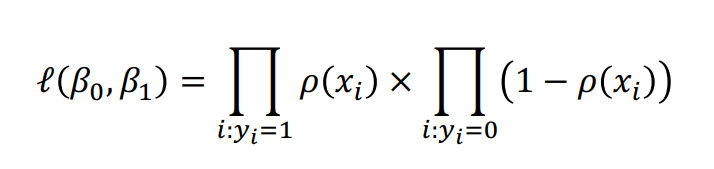

* ℓ(𝛽0,𝛽1) gives the probability of the observed training sequence happens.
* We pick 𝛽0 and 𝛽1 to maximize the resulted ℓ(𝛽0, 𝛽1) .

## Binary cross entropy
To chose values for the parameters of logistic regression, we use maximum likelihood estimation (MLE). 

The labels that we are predicting are binary,This means that we can (and should) interpret each label as a Bernoulli random variable: Y ∼ Ber(p) where p = σ(θT x).
To start, here is a super slick way of writing the probability of one data point (recall this is the equation form of the probability mass function of a Bernoulli):

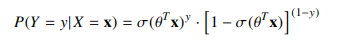

Now that we know the probability mass function, we can write the likelihood of all the data:

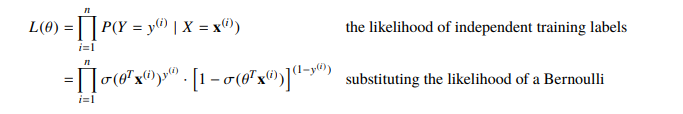

And if you take the log of this function, you get the log likelihood for logistic regression. The log likelihood equation is:

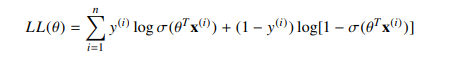

This function is called binary cross-entropy loss function and I will minimize this loss function with stochastic mini-batch Gradient descent in Tensorflow

In [21]:
class LogisticRegression(Model):
  def __init__(self):
    super(LogisticRegression, self).__init__()
    self.w = tf.Variable(tf.random.truncated_normal([784, 1]), trainable=True, name='w')
    self.b = tf.Variable(tf.zeros([1]), trainable=True, name='bias')
    self.loss = tf.keras.losses.BinaryCrossentropy()

  def predict(self, x):
    y_predicted= tf.nn.sigmoid(tf.matmul(x, self.w) + self.b)
    return np.round(y_predicted)

  def predict_proba(self, x):
    y_predicted= tf.nn.sigmoid(tf.matmul(x, self.w) + self.b)
    return y_predicted

  def accuracy(self,x,y):
    acc = accuracy_score(y_true=y , y_pred=self.predict(x))
    return acc 

  def ML(self,pred, target):
    #Maximum Likelihood
    return tf.math.reduce_prod((pred**target)*(1-pred)**(1-target))
  

The aim is to construct a logistic regression model where the input is 𝐱 (the vector
consists of all pixels of an image of size 784 (28*28) ) and the output is zero or
one (it is class “C” or “J”). The logistic regression can be written as:

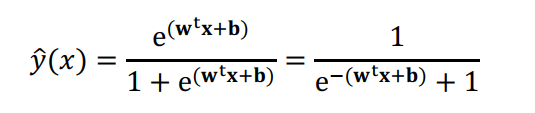

The goal is to find 𝐰 (of size 784) and **b** such that the loss function gets minimum.

In [22]:
model = LogisticRegression()

# Gradient descent

**Gradient descent** is a first-order iterative optimization algorithm for finding the minimum of a function. The goal of the gradient descent is to minimise a given function which, in our case, is the binary cross entropy loss function . To achieve this goal, it performs two steps iteratively:

1.   Compute the slope (gradient) that is the first-orderderivative of the function at the current point 
2.   Move-in the opposite direction of the slope increase from the current point by the computed amount

There are different ways to compute the gradient and move-in the opposite direction of gradient . Let’s look into them one by one.

# 1.  Batch Gradient Descent
In Batch Gradient Descent, all the training data is taken into consideration to take a single step. We take the average of the gradients of all the training examples and then use that mean gradient to update our parameters. So that’s just one step of gradient descent in one epoch.


One cycle through entire training datasets is called a training epoch. Therefore, it is often said that BGD performs model updates at the end of each training epoch.

It is more computationally efficient but memory consumption is too high and this happens in each and every step.


# 2. Stochastic Gradient Descent
In Batch Gradient Descent we were considering all the examples for every step of Gradient Descent. But what if our dataset is very huge. Suppose our dataset has 5 million examples, then just to take one step the model will have to calculate the gradients of all the 5 million examples. This does not seem an efficient way. To tackle this problem we have Stochastic Gradient Descent. In Stochastic Gradient Descent (SGD), we consider just one example at a time to take a single step. 

Since we are considering just one example at a time the cost will fluctuate over the training examples and it will not necessarily decrease. But in the long run, you will see the cost decreasing with fluctuations.

So, for every record, we are updating the weights and Weight updates is faster. Memory consumptions will also be low.
but because the cost is so fluctuating, it will never reach the minima but it will keep dancing around it.


# 3. Mini-Batch Gradient Descent
Batch Gradient Descent can be used for smoother curves. SGD can be used when the dataset is large. Batch Gradient Descent converges directly to minima. SGD converges faster for larger datasets. But, since in SGD we use only one example at a time, we cannot implement the vectorized implementation on it. This can slow down the computations. To tackle this problem, a mixture of Batch Gradient Descent and SGD is used. Neither we use all the dataset all at once nor we use the single example at a time. We use a batch of a fixed number of training examples which is less than the actual dataset and call it a mini-batch . 

# 4. Stochastic mini-batch Gradient descent

In Stochastic mini-batch Gradient descent we process batches of data obtained by a random permutation of the training data (i.e., each observation is processed only once per epoch, albeit in random order).Actually we should shuffle our training dataset in each epoch.
Stochastic mini batch Gradient offers the best of both worlds: computational and statistical efficiency.

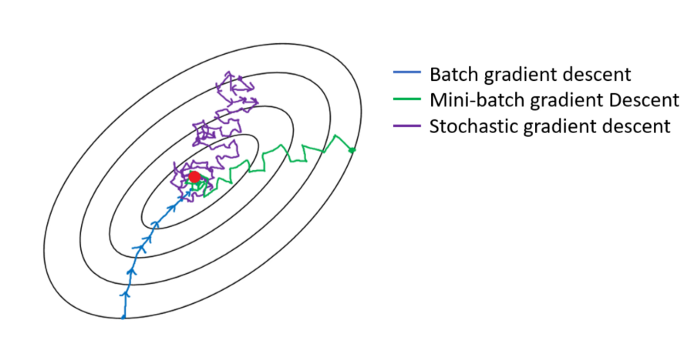



In [23]:
optimizer = tf.keras.optimizers.Adam(learning_rate=.1)
n_epochs = 5
batch_size = 256
loss_list =[]
train_acc =[]
test_acc  =[]
valid_acc =[]

In [24]:
def train_step(X, Y):
  with tf.GradientTape() as tape:
    loss = model.loss(y_pred = model.predict_proba(X) , y_true=Y)
    loss_list.append(loss)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [25]:
for epoch in range(n_epochs):
  index = np.random.choice(trainTarget.shape[0],trainTarget.shape[0])
  trainData = trainData[index,:]
  trainTarget = trainTarget[index]
  for iter in range(int(trainTarget.shape[0]/batch_size)):
    trainData_batch = trainData[iter*batch_size:(iter+1)*batch_size, :]
    trainTarget_batch = trainTarget[iter*batch_size:(iter+1)*batch_size]
    train_step( trainData_batch , trainTarget_batch )

    train_acc.append(model.accuracy(trainData, trainTarget))
    test_acc.append(model.accuracy(testData, testTarget))
    valid_acc.append(model.accuracy(validData, validTarget))

Text(0.5, 1.0, 'Loss vs Epochs')

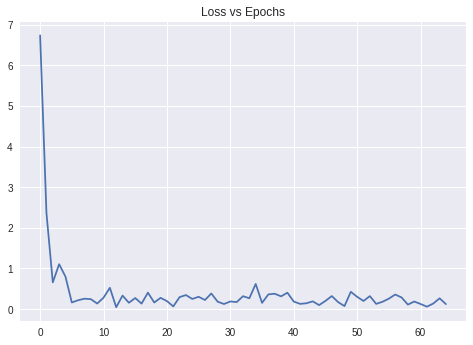

In [37]:
plt.plot(loss_list)
plt.title("Loss vs Epochs")

confusion_matrix() returns the confusion matrix, C where $C_{0,0}$ are the true negatives (TN) and $C_{0,1}$ the false positives (FP) and vice-versa for the positives in the 2nd row

Accuracy of train set : 0.986
confusion_matrix of train : 
[[1810   33]
 [  16 1641]]



Text(0.5, 1.0, 'Accuracy of train')

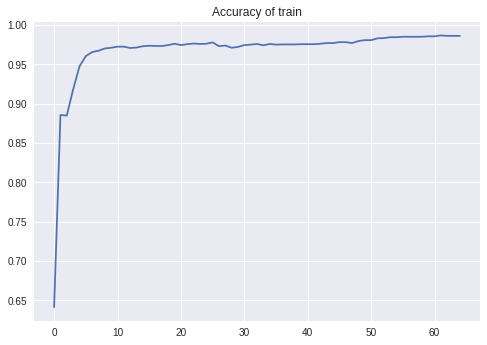

In [33]:
print(f"Accuracy of train set : {model.accuracy(trainData,trainTarget)}")
print(f"confusion_matrix of train : \n{confusion_matrix(trainTarget, model.predict(trainData))}\n")
plt.plot(train_acc)
plt.title("Accuracy of train")


Accuracy of valid set : 0.98
confusion_matrix of valid : 
[[46  0]
 [ 2 52]]



Text(0.5, 1.0, 'Accuracy of valid')

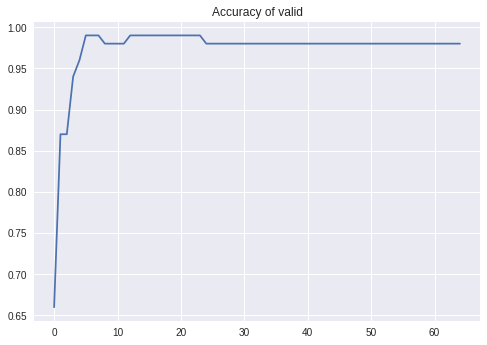

In [34]:
print(f"Accuracy of valid set : {model.accuracy( validData,validTarget)}")
print(f"confusion_matrix of valid : \n{confusion_matrix(validTarget, model.predict(validData))}\n")
plt.plot(valid_acc)
plt.title("Accuracy of valid")


Accuracy of test set : 0.9929078014184397
confusion_matrix of test : 
[[71  0]
 [ 1 69]]



Text(0.5, 1.0, 'Accuracy of test')

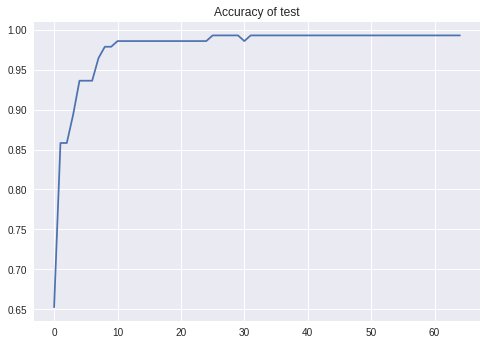

In [35]:
print(f"Accuracy of test set : {model.accuracy( testData,testTarget)}")
print(f"confusion_matrix of test : \n{confusion_matrix(testTarget, model.predict(testData))}\n")

plt.plot(test_acc)
plt.title("Accuracy of test")


With the method roc_auc_score()can we get the area under the receiver-operator-curve (AUC) for our simple model.

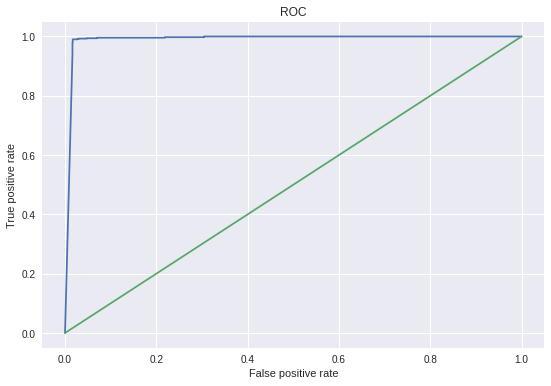

In [36]:
fpr, tpr, thresholds = roc_curve(trainTarget, model.predict_proba(trainData), drop_intermediate=True)

f, ax = plt.subplots(figsize=(9, 6))
_ = plt.plot(fpr, tpr, [0,1], [0, 1])
_ = plt.title('ROC')
_ = plt.xlabel('False positive rate')
_ = plt.ylabel('True positive rate')
